# MODEL IMPLEMENTATION AND EVALUATION

This is the stage where the three models are built, optimized and evaluated.

Models used: `` Multinominal Naive Bayes`` , ``Support Vector Machine``, ``Logistic Regression``, ``MLP Classifier``

Evaluation methods used: ``accuracy, precision, recall, f1_score`` and ``confusion matrix``

## Summary

After appropriate evaluation, LR with count vectorizer has been deemed the best. The rest of the models has all worked above 80% accuracy, with the other metrics working out above 79%. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#LIBRARIES 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import warnings
warnings.simplefilter("ignore")

In [3]:
#lOADING DATASETS 
df = pd.read_excel("/content/cleaned-data.xlsx")

toCheck = pd.read_excel("/content/updated-data.xlsx")
#REMOVE MAX
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#DROP EXTRA COLUMNS
df.drop(['Unnamed: 0'], axis=1, inplace=True)
toCheck.drop(['Unnamed: 0'], axis=1, inplace=True)

# DOUBLE-CHECKING...

Double checking if there are any NULL values within the dataset. This would cause issues later on if there are as such.

In [4]:
#CHECKING WHICH ROW IS NULL FROM PRE-PROCESSING
checkNULL = df.isnull()
checkNULL = checkNULL.any(axis=1)
df[checkNULL]

,review_text,verified_purchase
191,NaN,True
523,NaN,True
1072,NaN,True
1111,NaN,True
1230,NaN,True
1316,NaN,True


In [5]:
toCheck = toCheck.drop_duplicates().reset_index(drop=True)

In [6]:
toCheck.iloc[[191,523,1072,1111,1230,1316],[3,4]]

,review_text,verified_purchase
191,A+,True
523,5*,True
1072,very,True
1111,Does what it should,True
1230,A+,True
1316,A*****,True


Checking the old csv file, it can be seen as to why the five rows were totally cleaned out within its review_text. That was because within the text processing stage previously, only words which held meaning were kept, and if we refer to the second table we can see that most of them were either stopwords or had symbols and numbers. Since they don't hold meaning either way, these will be dropped subsequently. 

In [7]:
#DROP THE NULL ROWS
df = df.dropna(how='any',axis=0) 

In [8]:
#UPDATED VP VALUES 
df["verified_purchase"].value_counts(normalize=True)

False    0.525701
True     0.474299
Name: verified_purchase, dtype: float64

The change barely had any affect on the T/F values, and thus we are ready to proceed.

# MODELING

Within the dataset, there are currently only two columns. Out of the two, review_text is going to be assigned as the input variable, and verified_purchases as the target variable. The data is then going to be split accordingly.

In [9]:
#ASSIGN THE VARIABLES
X = df['review_text'] #input var
y = df['verified_purchase'] #target var

In [10]:
#SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    df['review_text'], df['verified_purchase'],test_size=0.4, random_state=42) #40% gives best results, 42 is no of life...

entiredf = format(df.shape[0])
traindf = format(X_train.shape[0])
testdf = format(X_test.shape[0])

print('Number of rows:')
print('Entire dataset:', entiredf)
print('Train dataset:', traindf)
print('Test dataset:',testdf)

Number of rows:
Entire dataset: 1712
Train dataset: 1027
Test dataset: 685


The data is decided to be split into 60 - 40, which has been determined by trial and error. This splitting produces the highest accuracy for the models, and thus we are going to with that. 

## COUNT VECTORIZER AND MODELING

word vectorization maps words or phrases from a lexicon to a matching vector of real numbers, which may then be used to determine word predictions and semantics, and this is done due to the fact that models only understand numerical data.

We are going to be utlizing two of the vectorization methods, the first one being count vectorizer. We just count the number of times a word appears in the document in CountVectorizer, which results in a bias in favor of the most common terms.

In [11]:
count_vectorizer  = CountVectorizer(stop_words='english')
count_vectorizer.fit(X_train)
print('\nVocabulary: \n', count_vectorizer.vocabulary_)

train_c = count_vectorizer.fit_transform(X_train)
test_c = count_vectorizer.transform(X_test)


Vocabulary: 
 {'current': 415, 'sell': 1498, 'price': 1310, 'compar': 343, 'supermarket': 1705, 'good': 761, 'smell': 1563, 'pleasant': 1270, 'need': 1134, 'add': 14, 'small': 1558, 'cloth': 321, 'fresh': 701, 'great': 777, 'moisturis': 1100, 'sensit': 1502, 'love': 1010, 'pour': 1293, 'smaller': 1559, 'bottl': 194, 'make': 1033, 'manag': 1037, 'beat': 137, 'decent': 434, 'fabric': 616, 'soften': 1580, 'nice': 1142, 'fragranc': 696, 'purchas': 1334, 'deliveri': 458, 'cream': 399, 'handwash': 802, 'cheaper': 282, 'hand': 799, 'better': 155, 'liquid': 989, 'oh': 1174, 'wing': 1916, 'dove': 516, 'kitchen': 941, 'bathroom': 131, 'shower': 1527, 'room': 1436, 'recommend': 1378, 'highli': 831, 'star': 1636, 'simpl': 1537, 'gel': 728, 'like': 978, 'glue': 754, 'hard': 806, 'rub': 1444, 'slip': 1555, 'bath': 130, 'goe': 757, 'smoothli': 1569, 'easili': 541, 'wast': 1884, 'leav': 965, 'feel': 645, 'silki': 1535, 'soft': 1579, 'scenti': 1477, 'review': 1419, 'collect': 328, 'promot': 1322, 'exc

### Multinomial Naive Bayes model

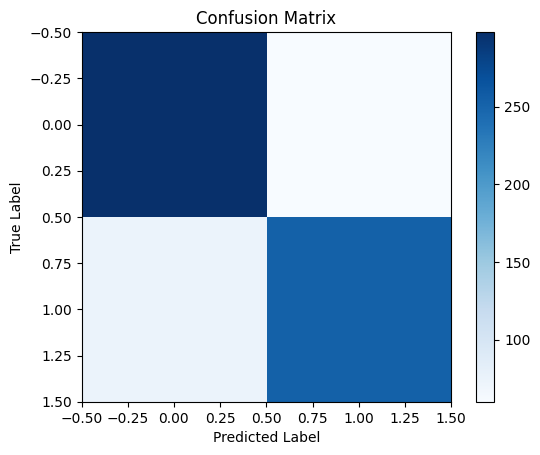

In [12]:
#IMPLEMENTING AND RUNNNING MNB MODEL - COUNT
mnb = MultinomialNB()
mnb.fit(train_c, y_train)
prediction = mnb.predict(test_c)

#EVALUATION
mnb_a1 = accuracy_score(y_test, prediction)*100
mnb_p1 = precision_score(y_test, prediction)* 100
mnb_r1 = recall_score(y_test, prediction)*100
mnb_f11 = f1_score(y_test, prediction)*100

#CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, prediction, labels=mnb.classes_)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() 

In [13]:
print('Model performance')
print('- Accuracy: %s' % mnb_a1)
print('- Precision: %s' % mnb_p1)
print('- Recall: %s' % mnb_r1)
print('- F1 score: %s' % mnb_f11)

Model performance
- Accuracy: 80.43795620437956
- Precision: 80.83067092651757
- Recall: 77.37003058103976
- F1 score: 79.0625


### Support Vector Machine model

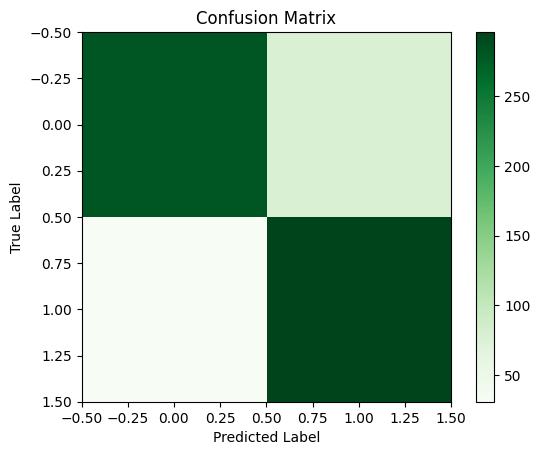

In [14]:
#IMPLEMENTING AND RUNNNING SVM MODEL - COUNT
svm = SVC(kernel='linear')
svm.fit(train_c, y_train)
prediction = svm.predict(test_c)

#EVALUATION
svm_a1 = accuracy_score(y_test, prediction)*100
svm_p1 = precision_score(y_test, prediction)* 100
svm_r1 = recall_score(y_test, prediction)*100
svm_f11 = f1_score(y_test, prediction)*100

#CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, prediction, labels=svm.classes_)
plt.imshow(cm, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()  

In [15]:
print('Model performance')
print('- Accuracy: %s' % svm_a1)
print('- Precision: %s' % svm_p1)
print('- Recall: %s' % svm_r1)
print('- F1 score: %s' % svm_f11)

Model performance
- Accuracy: 84.23357664233576
- Precision: 79.35656836461126
- Recall: 90.51987767584097
- F1 score: 84.57142857142857


### Logistic Regression model

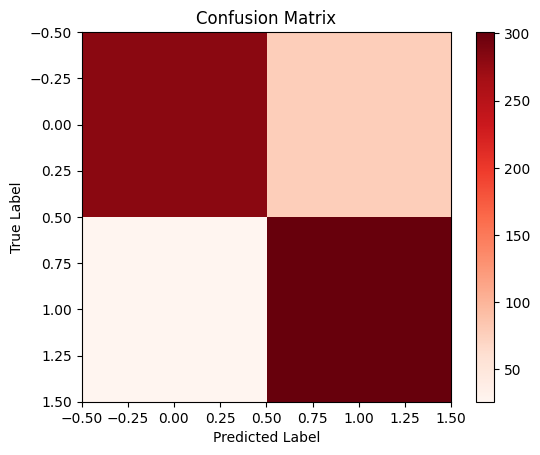

In [16]:
#IMPLEMENTING AND RUNNNING LR MODEL - COUNT
lr = LogisticRegression()
lr.fit(train_c, y_train)
prediction = lr.predict(test_c)

#EVALUATION
lr_a1 = accuracy_score(y_test, prediction)*100
lr_p1 = precision_score(y_test, prediction)* 100
lr_r1 = recall_score(y_test, prediction)*100
lr_f11 = f1_score(y_test, prediction)*100

#CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, prediction, labels=lr.classes_)
plt.imshow(cm, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() 

In [17]:
print('Model performance')
print('- Accuracy: %s' % lr_a1)
print('- Precision: %s' % lr_p1)
print('- Recall: %s' % lr_r1)
print('- F1 score: %s' % lr_f11)

Model performance
- Accuracy: 84.96350364963504
- Precision: 79.62962962962963
- Recall: 92.04892966360856
- F1 score: 85.39007092198581


### Neural Network model

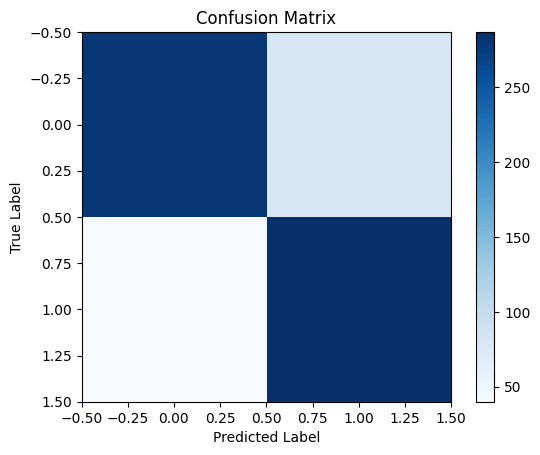

In [18]:
#IMPLEMENTING AND RUNNNING NEURAL NETWORK MODEL - COUNT
MLPClassifier = MLPClassifier()
MLPClassifier.fit(train_c, y_train)
prediction = MLPClassifier.predict(test_c)

#EVALUATION
MLPClassifier_a1 = accuracy_score(y_test, prediction)*100
MLPClassifier_p1 = precision_score(y_test, prediction)* 100
MLPClassifier_r1 = recall_score(y_test, prediction)*100
MLPClassifier_f11 = f1_score(y_test, prediction)*100

#CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, prediction, labels=MLPClassifier.classes_)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() 

In [19]:
print('Model performance')
print('- Accuracy: %s' % MLPClassifier_a1)
print('- Precision: %s' % MLPClassifier_p1)
print('- Recall: %s' % MLPClassifier_r1)
print('- F1 score: %s' % MLPClassifier_f11)

Model performance
- Accuracy: 82.77372262773723
- Precision: 78.63013698630137
- Recall: 87.76758409785933
- F1 score: 82.94797687861272


### Build Stacked model

In [20]:
estimator_list = [
    ('mnb' ,mnb),
    ('svm',svm),
    ('lr',lr),
    ('MLPClassifier',MLPClassifier) ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_model.fit(train_c, y_train)

# Make predictions
prediction = stack_model.predict(test_c)

# Model performance
stack_model_a1 = accuracy_score(y_test, prediction)*100
stack_model_p1 = precision_score(y_test, prediction)* 100
stack_model_r1 = recall_score(y_test, prediction)*100
stack_model_f11 = f1_score(y_test, prediction)*100

print('Model performance')
print('- Accuracy: %s' % stack_model_a1)
print('- Precision: %s' % stack_model_p1)
print('- Recall: %s' % stack_model_r1)
print('- F1 score: %s' % stack_model_f11)

Model performance
- Accuracy: 86.27737226277372
- Precision: 83.1908831908832
- Recall: 89.29663608562691
- F1 score: 86.13569321533923


### Results

In [21]:
a1_list = {'mnb':mnb_a1,
'lr': lr_a1,
'svm': svm_a1,
'MLPClassifier': MLPClassifier_a1,
'stack': stack_model_a1}

p1_list = {'mnb':mnb_p1,
'lr':lr_p1,
'svm': svm_p1,
'MLPClassifier': MLPClassifier_p1,
'stack': stack_model_p1}

r1_list = {'mnb':mnb_r1,
'lr':lr_r1,
'svm': svm_r1,
'MLPClassifier': MLPClassifier_r1,
'stack': stack_model_r1}
    
f11_list = {'mnb':mnb_f11,
'lr':lr_f11,
'svm': svm_f11,
'MLPClassifier': MLPClassifier_f11,
'stack': stack_model_f11}

In [22]:
a1_list

{'mnb': 80.43795620437956,
 'lr': 84.96350364963504,
 'svm': 84.23357664233576,
 'MLPClassifier': 82.77372262773723,
 'stack': 86.27737226277372}

In [23]:
p1_list

{'mnb': 80.83067092651757,
 'lr': 79.62962962962963,
 'svm': 79.35656836461126,
 'MLPClassifier': 78.63013698630137,
 'stack': 83.1908831908832}

In [24]:
r1_list

{'mnb': 77.37003058103976,
 'lr': 92.04892966360856,
 'svm': 90.51987767584097,
 'MLPClassifier': 87.76758409785933,
 'stack': 89.29663608562691}

In [25]:
f11_list

{'mnb': 79.0625,
 'lr': 85.39007092198581,
 'svm': 84.57142857142857,
 'MLPClassifier': 82.94797687861272,
 'stack': 86.13569321533923}

In [26]:
import pandas as pd

a1_df = pd.DataFrame.from_dict(a1_list, orient='index', columns=['Accuracy'])
p1_df = pd.DataFrame.from_dict(p1_list, orient='index', columns=['Precision'])
r1_df = pd.DataFrame.from_dict(r1_list, orient='index', columns=['Recall'])
f11_df = pd.DataFrame.from_dict(f11_list, orient='index', columns=['F1'])
df = pd.concat([a1_df, p1_df, r1_df, f11_df], axis=1)
df

,Accuracy,Precision,Recall,F1
mnb,80.437956,80.830671,77.370031,79.062500
lr,84.963504,79.629630,92.048930,85.390071
svm,84.233577,79.356568,90.519878,84.571429
MLPClassifier,82.773723,78.630137,87.767584,82.947977
stack,86.277372,83.190883,89.296636,86.135693


In [27]:
#SAVING THE COMBINED MODEL(named as: STACK) WITH COUNT VECTORIZER
pickle.dump(mnb, open('/content/mnb-model.pkl', 'wb'))
pickle.dump(svm, open('/content/svm-model.pkl', 'wb'))
pickle.dump(lr, open('/content/lr-model.pkl', 'wb'))
pickle.dump(MLPClassifier, open('/content/MLPClassifier-model.pkl', 'wb'))
pickle.dump(stack_model, open('/content/stacked-model.pkl', 'wb'))
pickle.dump(count_vectorizer, open('/content/count-vectorizer.pkl', 'wb'))